In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from tqdm.notebook import tqdm
from torchdiffeq import odeint

from deq_vdp.train import load_from_wandb

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [33]:
h0 = torch.zeros(4,1)
h0[0,0] = 12.6
h0[1,0] = 13.0
h0[2,0] = 4.8
h0[3,0] = 4.9

u0 = torch.zeros(2,1)
u0[0,0] = 3.15
u0[1,0] = 3.15

def four_tanks(h, u):
    assert h.device == u.device

    g = [.43, .34]
    k = [3.14, 3.29]
    K = torch.Tensor([
        [g[0]*k[0], 0],
        [0, g[1]*k[1]],
        [0, (1-g[1])*k[1]],
        [(1-g[0])*k[0], 0],
    ]).to(h.device)

    a = [.071, .057, .071, .057]
    g = 981
    W = torch.Tensor([
        [-a[0],     0,  a[2],     0],
        [    0, -a[1],     0,  a[3]],
        [    0,     0, -a[2],     0],
        [    0,     0,     0, -a[3]],
    ]).to(h.device)

    A = torch.Tensor([1/28, 1/32, 1/28, 1/32]).unsqueeze(-1).to(h.device)
    return A * (K @ u + W @ torch.sqrt(2*g*h))

four_tanks(h0,u0)

tensor([[-0.0007],
        [ 0.0003],
        [-0.0018],
        [ 0.0015]])

In [50]:
h = torch.stack([h0,h0,h0])
u = torch.stack([u0,u0,u0])

dh = four_tanks(h,u)
(dh == dh[0]).all()

tensor(True)

Solving using 4th order Runge-Kutta.

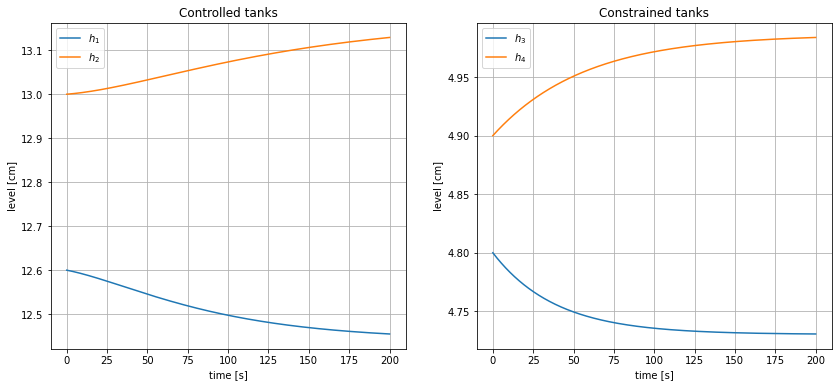

In [63]:
dt = .1
N = 2000
h = odeint(lambda t, h: four_tanks(h,u0), h0, torch.Tensor([i * dt for i in range(N+1)]), method='rk4')

h_ = h.detach().numpy()

time = [dt * k for k in range(N+1)]

fig, axs = plt.subplots(1,2)
fig.set_size_inches(14,6)

axs[0].set_title('Controlled tanks')
axs[0].plot(time, h_[:,0], label='$h_1$')
axs[0].plot(time, h_[:,1], label='$h_2$')
axs[0].set_ylabel('level [cm]')
axs[0].set_xlabel('time [s]')
axs[0].legend()
axs[0].grid()

axs[1].set_title('Constrained tanks')
axs[1].plot(time, h_[:,2], label='$h_3$')
axs[1].plot(time, h_[:,3], label='$h_4$')
axs[1].set_ylabel('level [cm]')
axs[1].set_xlabel('time [s]')
axs[1].legend()
axs[1].grid()

plt.show()

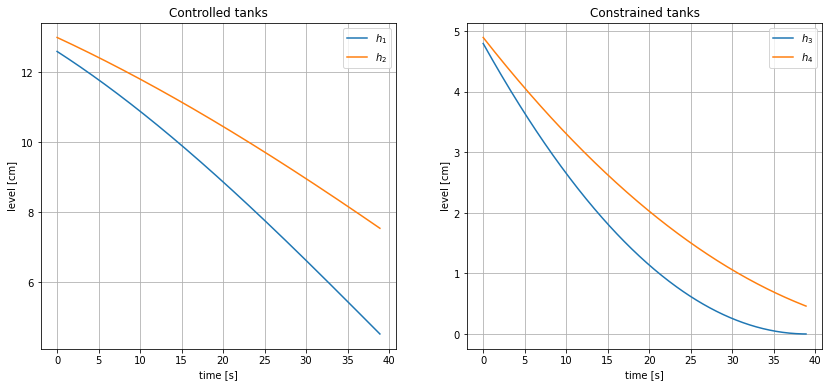

In [62]:
dt = .1
N = 2000
h = odeint(lambda t, h: four_tanks(h,torch.zeros(2,1)), h0, torch.Tensor([i * dt for i in range(N+1)]), method='rk4')

h_ = h.detach().numpy()

time = [dt * k for k in range(N+1)]

fig, axs = plt.subplots(1,2)
fig.set_size_inches(14,6)

axs[0].set_title('Controlled tanks')
axs[0].plot(time, h_[:,0], label='$h_1$')
axs[0].plot(time, h_[:,1], label='$h_2$')
axs[0].set_ylabel('level [cm]')
axs[0].set_xlabel('time [s]')
axs[0].legend()
axs[0].grid()

axs[1].set_title('Constrained tanks')
axs[1].plot(time, h_[:,2], label='$h_3$')
axs[1].plot(time, h_[:,3], label='$h_4$')
axs[1].set_ylabel('level [cm]')
axs[1].set_xlabel('time [s]')
axs[1].legend()
axs[1].grid()

plt.show()